In [32]:
from qiskit import QuantumCircuit, Aer, execute,QuantumRegister, ClassicalRegister
from qiskit.visualization import circuit_drawer
from qiskit.circuit.library import standard_gates
from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.transpiler.passes import RemoveFinalMeasurements
from mitiq.interface import convert_to_mitiq, convert_from_mitiq
import numpy as np
import math as math
import matplotlib.pyplot as plt
from mitiq import zne
from mitiq.zne.scaling.layer_scaling import layer_folding

In [2]:
global depolarNoise

In [3]:
def get_noise(p, qubits=1):
    
    # This creates the depolarizing error channel,
    depo_err_chan = depolarizing_error(p, qubits)

    # Creating the noise model to be used during execution.
    noise_model = NoiseModel()

    noise_model.add_all_qubit_quantum_error(depo_err_chan, "measure") # measurement error is applied to measurements

    return noise_model, depo_err_chan

In [4]:
def createCircuit(statevector_A, statevector_B, no_of_qubits):

    
    
    # Create a quantum circuit with three qubits (A, B, and C)
    c = ClassicalRegister(1,'c') #classical Register
    q = QuantumRegister(2*no_of_qubits + 1,'q')
    qc = QuantumCircuit(q, c)
    
    # Apply Hadamard to ancillas
    #for i in range(no_of_qubits):
    qc.h(q[0])  

    # Initialize quantum states A and B
    qc.initialize(statevector_A, q[1:no_of_qubits+1])
    qc.initialize(statevector_B, q[no_of_qubits+1:2*no_of_qubits+1])
    
    # Implement the controlled-Swap (CSwap) gate
    for i in range(no_of_qubits):
        qc.cswap(q[0], q[i + 1], q[i+1+no_of_qubits])

    
    # Apply inverse Hadamard gates
    #for i in range(no_of_qubits):
    qc.h(0)  

    # Measure the ancilla qubit C
    #for i in range(no_of_qubits):
    qc.measure(q[0],c[0])

    return qc

In [5]:
def executeSwap(qc):

    noise_model, depo_err_chan = get_noise(depolarNoise,1)
    
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    no_of_shots = 10000
    job = execute(qc, simulator,noise_model=noise_model, shots=no_of_shots)
    result = job.result()
    
    # Get the counts
    counts = result.get_counts(qc)

    #count of measurement of each register
    measurement_prob = {}

    for outcome, count in counts.items():
        measurement_prob[outcome] = int(count)/no_of_shots
    return measurement_prob

def executeSwap_Mitigation(qc , shots=10 ** 4):

    noise_model, depo_err_chan = get_noise(depolarNoise,1)

    qc.measure(q[0],c[0])
    # Simulate the circuit
    simulator = Aer.get_backend('qasm_simulator')
    no_of_shots = 10000
    job = execute(qc, simulator,noise_model=noise_model, shots=no_of_shots)
    result = job.result()
    
    # Get the counts
    counts = result.get_counts(qc)

    #count of measurement of each register
    measurement_prob = {}

    for outcome, count in counts.items():
        measurement_prob[outcome] = int(count)/no_of_shots
    return measurement_prob
    

def swapTest(qc , depolarNoise = 0):
    
    measurement_prob = executeSwap(qc)
    sum_dict = {}

    for key, value in measurement_prob.items():
        for i, digit in enumerate(key):
            if digit == '1':
                # Add the value to the corresponding sum in the new dictionary
                if i in sum_dict:
                    sum_dict[i] += value
                else:
                    sum_dict[i] = value

    ind_overlap = {}
    for key, value in sum_dict.items():
        
        ind_overlap[key] = 1-(2*value)
    
    overlap = 1              
    for value in ind_overlap.values():
        overlap *= value

    return round(overlap,4)



In [6]:
def swapTest_Mitigation(qc):

    qc = RemoveFinalMeasurements()(qc)
    qc = convert_from_mitiq(convert_to_mitiq(qc)[0], "qiskit")
    measurement_prob = zne.execute_with_zne(qc, executeSwap_Mitigation)
    
    sum_dict = {}

    for key, value in measurement_prob.items():
        for i, digit in enumerate(key):
            if digit == '1':
                # Add the value to the corresponding sum in the new dictionary
                if i in sum_dict:
                    sum_dict[i] += value
                else:
                    sum_dict[i] = value

    ind_overlap = {}
    for key, value in sum_dict.items():
        
        ind_overlap[key] = 1-(2*value)
    
    overlap = 1              
    for value in ind_overlap.values():
        overlap *= value

    return round(overlap,4)

In [7]:
def check_overlap(vector1, vector2):
    
    # Calculate the dot product between the vectors
    dot_product = np.dot(vector1, vector2)
    
    # Square the dot product
    squared_dot_product = dot_product ** 2
    return squared_dot_product

In [8]:
def plot_noiseVsOverlap(data, title):
    keys = list(data.keys())
    values = list(data.values())

    # Convert the lists to numpy arrays for linear regression
    x = np.array(keys)
    y = np.array(values)
    
    # Calculate the slope and intercept of the linear fit
    slope, intercept = np.polyfit(x, y, 1)

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(keys, values, marker='o')
    plt.axhline(y=values[0], color='g', linestyle='--', label='Overlap at Zero Noise')
    plt.plot(x, slope * x + intercept, color='r', label=f'Linear Fit (Slope = {slope:.2f})')

    plt.ylim(0, 1)
    # Set labels and title
    plt.xlabel('Noise')
    plt.ylabel('Overlap')
    plt.title(title)
    
    # Add a legend
    plt.legend()
    
    # Show the plot
    plt.grid(True)
    plt.show()


# <span style="color:purple">**INITAL CHECK WITH ZERO NOISE**</span>

## 1st Ques

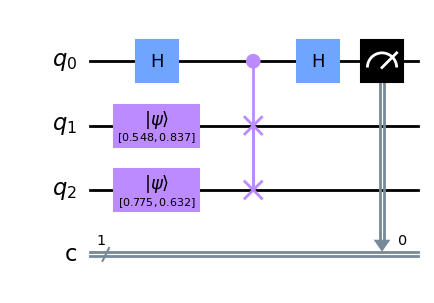

In [9]:

statvector1A = [0.3**0.5,0.7**0.5]
statevector1B = [0.6**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector1A),2))
qc = createCircuit(statvector1A,statevector1B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [10]:

depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector1A,statevector1B)
print("SWAP TEST OVERLAP: ", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP:  0.9062
OVERLAP found mathematically: 0.908998886412873
SWAP TEST works correctly


## 2nd Ques

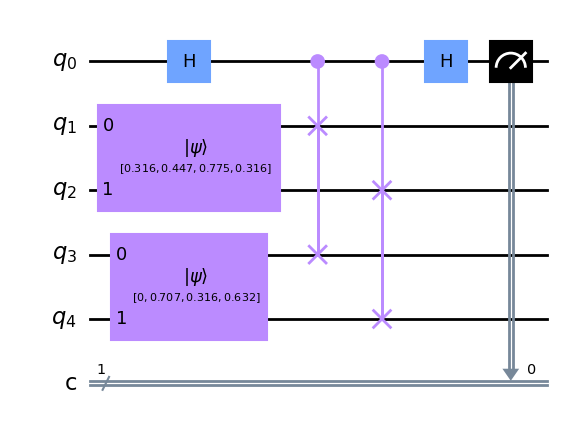

In [11]:

statvector2A = [0.1**0.5, 0.2**0.5, 0.6**0.5,0.1**0.5]
statevector2B = [0.0**0.5,0.5**0.5, 0.1**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector2A),2))
qc = createCircuit(statvector2A,statevector2B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [12]:
depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector2A,statevector2B)
print("SWAP TEST OVERLAP:", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP: 0.5716
OVERLAP found mathematically: 0.5793900299663589
SWAP TEST works correctly


## 3rd Ques

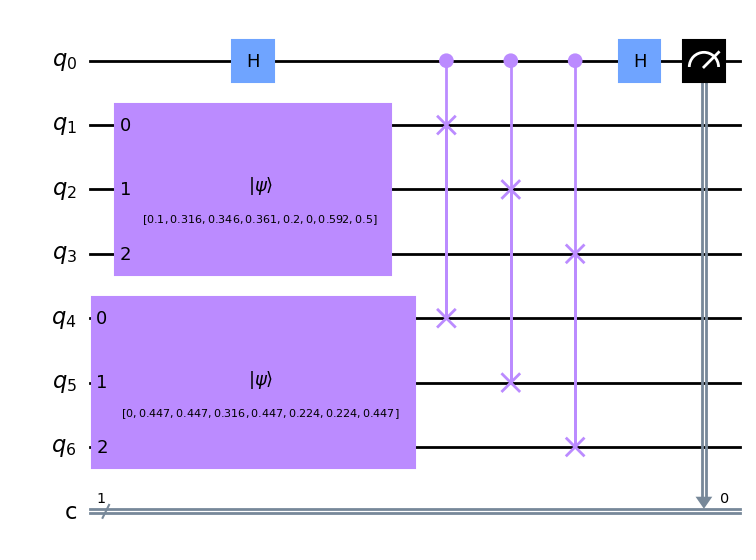

In [13]:

statvector3A = [0.01**0.5, 0.1**0.5, 0.12**0.5,0.13**0.5,0.04**0.5,0,0.35**0.5,0.25**0.5]
statevector3B = [0.00**0.5, 0.2**0.5, 0.2**0.5,0.1**0.5,0.2**0.5,0.05**0.5,0.05**0.5,0.2**0.5]
no_of_qubits = int(math.log(len(statvector3A),2))
qc = createCircuit(statvector3A,statevector3B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [14]:
depolarNoise = 0
overlap = swapTest(qc)
test_overlap = check_overlap(statvector3A,statevector3B)
print("SWAP TEST OVERLAP: ", overlap)
print("OVERLAP found mathematically:", test_overlap)
if abs(test_overlap-overlap) <= 0.02:
    print("SWAP TEST works correctly")
else:
    print("SWAP TEST does not agree with mathematical overlap")

SWAP TEST OVERLAP:  0.7364
OVERLAP found mathematically: 0.7322144721107586
SWAP TEST works correctly


# <span style="color:purple">**Simulating SWAP TEST with Depolarizing Noise**</span>

## 1st Ques

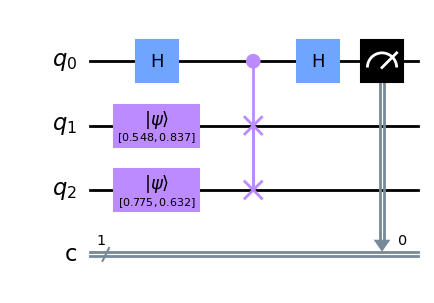

In [15]:
statvector1A = [0.3**0.5,0.7**0.5]
statevector1B = [0.6**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector1A),2))
qc = createCircuit(statvector1A,statevector1B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [16]:
depolarNoise = 0
stepSize = 0.01
ques_1_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_1_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)  


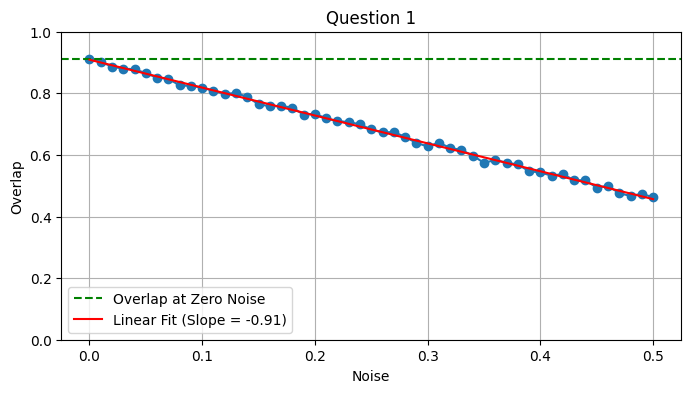

In [17]:
plot_noiseVsOverlap(ques_1_noiseVsOverlap, "Question 1")

# 2nd Ques

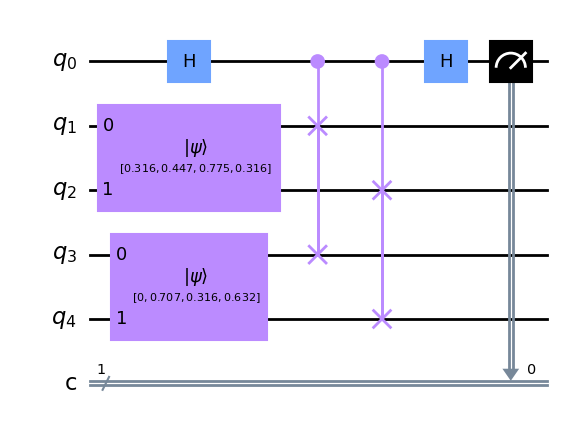

In [18]:

statvector2A = [0.1**0.5, 0.2**0.5, 0.6**0.5,0.1**0.5]
statevector2B = [0.0**0.5,0.5**0.5, 0.1**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector2A),2))
qc = createCircuit(statvector2A,statevector2B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [19]:
depolarNoise = 0
stepSize = 0.01
ques_2_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_2_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)

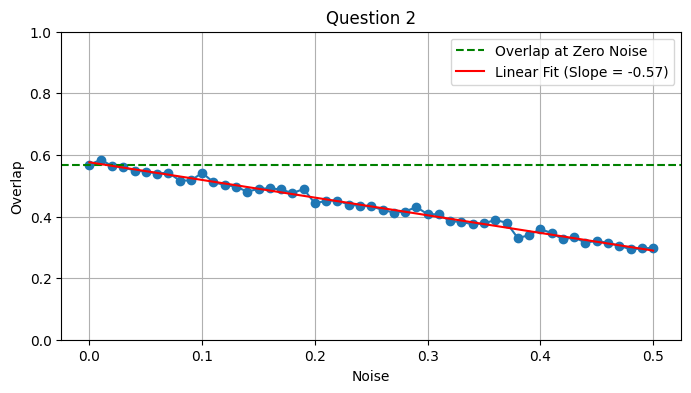

In [20]:
plot_noiseVsOverlap(ques_2_noiseVsOverlap, "Question 2")

# 3rd Ques

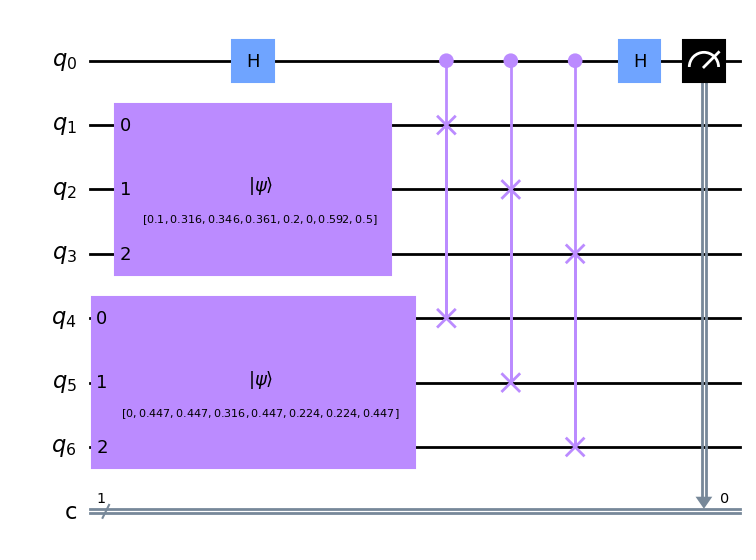

In [21]:

statvector3A = [0.01**0.5, 0.1**0.5, 0.12**0.5,0.13**0.5,0.04**0.5,0,0.35**0.5,0.25**0.5]
statevector3B = [0.00**0.5, 0.2**0.5, 0.2**0.5,0.1**0.5,0.2**0.5,0.05**0.5,0.05**0.5,0.2**0.5]
no_of_qubits = int(math.log(len(statvector3A),2))
qc = createCircuit(statvector3A,statevector3B, no_of_qubits)

circuit_drawer(qc, output='mpl')

In [22]:
depolarNoise = 0
stepSize = 0.01
ques_3_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest(qc)
    ques_3_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)

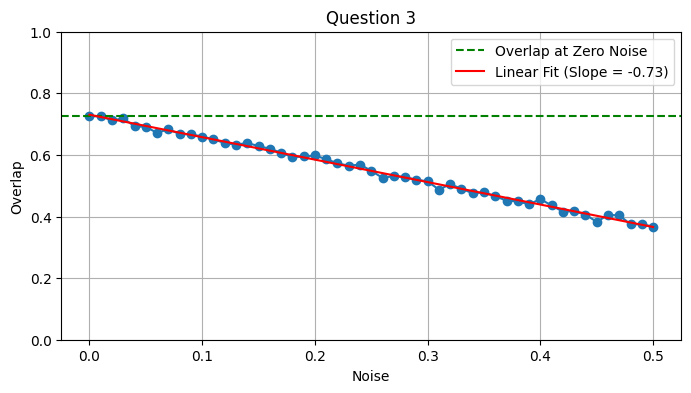

In [23]:
plot_noiseVsOverlap(ques_3_noiseVsOverlap, "Question 3")

# **OBSERVATIONS ON NOISE vs OVERLAP GRAPH WITH NO MITIGATION DONE**

* The depolarizing noise causes the overlap to always reduce linearly.
* The absolute value of the slope of the line that linearly fits the graph is equal to the overlap when no noise is present

# <span style="color:purple">**Simulating SWAP TEST with Depolarizing Noise and use ZNE mitigation technique**</span>

In [24]:
statvector1A = [0.3**0.5,0.7**0.5]
statevector1B = [0.6**0.5,0.4**0.5]
no_of_qubits = int(math.log(len(statvector1A),2))
qc = createCircuit(statvector1A,statevector1B, no_of_qubits)

In [29]:
depolarNoise = 0
stepSize = 0.01
ques_1_noiseVsOverlap = {}

while depolarNoise <= 0.5:
    overlap = swapTest_Mitigation(qc)
    ques_1_noiseVsOverlap[depolarNoise] = overlap
    depolarNoise = round(depolarNoise + stepSize, 2)  


CircuitConversionError: Circuit could not be converted to an internal Mitiq circuit. This may be because the circuit contains custom gates or Pragmas (pyQuil). If you think this is a bug or that this circuit should be supported, you can open an issue at https://github.com/unitaryfund/mitiq. 

 Provided circuit has type <class 'qiskit.circuit.quantumcircuit.QuantumCircuit'> and is:

                  ┌───┐                ┌───┐
q_0: ─────────────┤ H ├──────────────■─┤ H ├
     ┌────────────┴───┴────────────┐ │ └───┘
q_1: ┤ Initialize(0.54772,0.83666) ├─X──────
     └┬────────────────────────────┤ │      
q_2: ─┤ Initialize(0.7746,0.63246) ├─X──────
      └────────────────────────────┘        

Circuit types supported by Mitiq are 
{'cirq': 'Circuit', 'pyquil': 'Program', 'qiskit': 'QuantumCircuit', 'braket': 'Circuit', 'pennylane': 'QuantumTape'}.